In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/home/bharaj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [5]:
df = pd.read_csv('Tamil_first_ready_for_sentiment.csv',sep='\t',names=['category','text'])
print(df.shape)

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

(15744, 2)


In [18]:
diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'Negative ',
 1: 'Positive ',
 2: 'Mixed feelings ',
 3: 'not-Tamil ',
 4: 'unknown state '}

In [6]:
y=df['category']
#y = pd.get_dummies(df['category']).values

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=5, test_size=0.2)

In [7]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [8]:
y_train=pd.get_dummies(y_train).values
y_test=pd.get_dummies(y_test).values

In [9]:
w2v = Word2Vec(size=100, window=5, min_count=4, seed=33)
w2v.build_vocab(X_train)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=10)

ft = FastText(size=100, window=5, min_count=4, seed=33)
ft.build_vocab(X_train)
ft.train(X_train, total_examples=ft.corpus_count, epochs=10)

max_len = 200

tokenizer = Tokenizer(lower=True, split='')
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(12595, 200) (3149, 200)


In [10]:
embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 17493


In [11]:
embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 0


In [12]:

def Concat_Emb(list_emb, maxlen):
    
    inputs = []
    output = []
    for embedding in list_emb:
        
        inp = Input(shape=(maxlen,))
        emb = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,100,1))(emb)
        inputs.append(inp)
        output.append(emb)
        
    concat = Concatenate(axis=-1)(output)
    
    return Model(inputs, concat)

In [13]:
read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

W0131 16:46:59.502100 139777492145920 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0131 16:46:59.528982 139777492145920 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0131 16:46:59.535554 139777492145920 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0131 16:46:59.549910 139777492145920 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     2045800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     2045800     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [14]:
def DME(maxlen):

    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = LSTM(2, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

def CDME(maxlen, latent_dim=2):
    
    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x = Lambda(lambda t: [t[:,:,:int(latent_dim/2+1)], t[:,:,int(latent_dim/2+1):]])(x)
    x = Maximum()(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

In [15]:
concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y_train.shape[1], activation='softmax',kernel_regularizer=regularizers.l1(0.01))(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

W0131 16:47:13.030189 139777492145920 deprecation.py:506] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0131 16:47:13.587147 139777492145920 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     2045800     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 100)     2045800     input_4[0][0]                    
__________________________________________________________________________________________________
reshape_3 

In [16]:
dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1,class_weight=class_weights)

W0131 16:47:22.818192 139777492145920 deprecation.py:323] From /home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11335 samples, validate on 1260 samples
Epoch 1/20
 - 108s - loss: 1.2982 - acc: 0.6630 - val_loss: 1.1915 - val_acc: 0.6810
Epoch 2/20
 - 96s - loss: 1.1624 - acc: 0.6762 - val_loss: 1.1131 - val_acc: 0.6849
Epoch 3/20
 - 88s - loss: 1.0902 - acc: 0.6820 - val_loss: 1.0654 - val_acc: 0.6857
Epoch 4/20
 - 94s - loss: 1.0441 - acc: 0.6850 - val_loss: 1.0294 - val_acc: 0.6849
Epoch 5/20
 - 95s - loss: 1.0134 - acc: 0.6846 - val_loss: 1.0119 - val_acc: 0.6857
Epoch 6/20
 - 98s - loss: 0.9946 - acc: 0.6849 - val_loss: 0.9947 - val_acc: 0.6857
Epoch 7/20
 - 98s - loss: 0.9808 - acc: 0.6858 - val_loss: 0.9901 - val_acc: 0.6833
Epoch 8/20
 - 100s - loss: 0.9727 - acc: 0.6863 - val_loss: 0.9870 - val_acc: 0.6889
Epoch 9/20
 - 90s - loss: 0.9650 - acc: 0.6876 - val_loss: 0.9785 - val_acc: 0.6873
Epoch 10/20
 - 89s - loss: 0.9563 - acc: 0.6873 - val_loss: 0.9759 - val_acc: 0.6889
Epoch 11/20
 - 90s - loss: 0.9533 - acc: 0.6895 - val_loss: 0.9717 - val_acc: 0.6897
Epoch 12/20
 - 93s - lo

In [19]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))

                 precision    recall  f1-score   support

Mixed feelings        0.68      0.99      0.80      2075
      Negative        0.29      0.01      0.01       377
      Positive        0.34      0.03      0.05       424
     not-Tamil        0.71      0.49      0.58       100
 unknown state        0.31      0.02      0.04       173

      micro avg       0.67      0.67      0.67      3149
      macro avg       0.46      0.31      0.30      3149
   weighted avg       0.57      0.67      0.56      3149



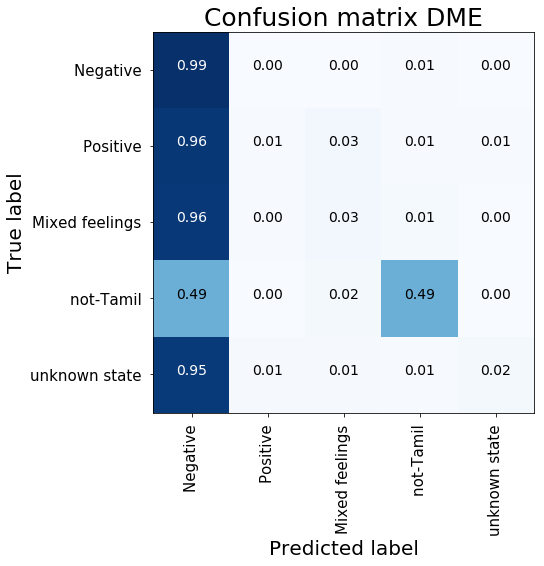

In [20]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

In [21]:
concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y_train.shape[1], activation='softmax',kernel_regularizer=regularizers.l1(0.01))(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cdme_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 100)     2045800     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 100)     2045800     input_7[0][0]                    
__________________________________________________________________________________________________
reshape_7 

In [22]:
cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1,class_weight=class_weights)

Train on 11335 samples, validate on 1260 samples
Epoch 1/20
 - 120s - loss: 1.3085 - acc: 0.6638 - val_loss: 1.1968 - val_acc: 0.6833
Epoch 2/20
 - 117s - loss: 1.1651 - acc: 0.6777 - val_loss: 1.1251 - val_acc: 0.6817
Epoch 3/20
 - 116s - loss: 1.1009 - acc: 0.6817 - val_loss: 1.0787 - val_acc: 0.6857
Epoch 4/20
 - 117s - loss: 1.0537 - acc: 0.6830 - val_loss: 1.0513 - val_acc: 0.6833
Epoch 5/20
 - 116s - loss: 1.0244 - acc: 0.6864 - val_loss: 1.0234 - val_acc: 0.6841
Epoch 6/20
 - 117s - loss: 1.0031 - acc: 0.6859 - val_loss: 1.0033 - val_acc: 0.6889
Epoch 7/20
 - 116s - loss: 0.9836 - acc: 0.6864 - val_loss: 0.9931 - val_acc: 0.6897
Epoch 8/20
 - 116s - loss: 0.9757 - acc: 0.6855 - val_loss: 0.9846 - val_acc: 0.6905
Epoch 9/20
 - 116s - loss: 0.9659 - acc: 0.6888 - val_loss: 0.9859 - val_acc: 0.6865
Epoch 10/20
 - 116s - loss: 0.9580 - acc: 0.6905 - val_loss: 0.9824 - val_acc: 0.6865
Epoch 11/20
 - 117s - loss: 0.9506 - acc: 0.6905 - val_loss: 0.9773 - val_acc: 0.6857
Epoch 12/20
 -

In [23]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)]))

                 precision    recall  f1-score   support

Mixed feelings        0.67      0.99      0.80      2075
      Negative        0.20      0.00      0.01       377
      Positive        0.56      0.01      0.02       424
     not-Tamil        0.68      0.52      0.59       100
 unknown state        0.56      0.03      0.05       173

      micro avg       0.67      0.67      0.67      3149
      macro avg       0.53      0.31      0.30      3149
   weighted avg       0.59      0.67      0.55      3149



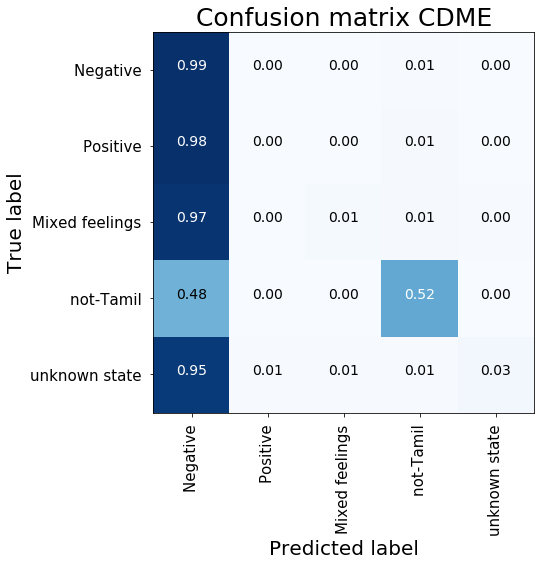

In [24]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix CDME")
plt.show()